Notebook
https://www.learnpytorch.io/01_pytorch_workflow/

In [215]:
%pip install torch torchvision torchaudio pandas numpy matplotlib tqdm;


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [216]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device

## 1. Data Preparing and Loading

### Generate some sample data
Usually this data comes from observations, but for this example we will generate it ourselves.

In [217]:
# Create data with known population parameters
W = 0.7
b = 0.3


start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step)

scale = 20
normal_noise = torch.randn(X.shape) / scale  # Drawn from normal distribution

Y = W * X + b + normal_noise


print(f"X: {X}")
print(f"Y: {Y}")
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900])
Y: tensor([0.3963, 0.3814, 0.3590, 0.2157, 0.3619, 0.2733, 0.3398, 0.2688, 0.3184,
        0.4454, 0

Text(0, 0.5, 'Y = W*X + b + ε')

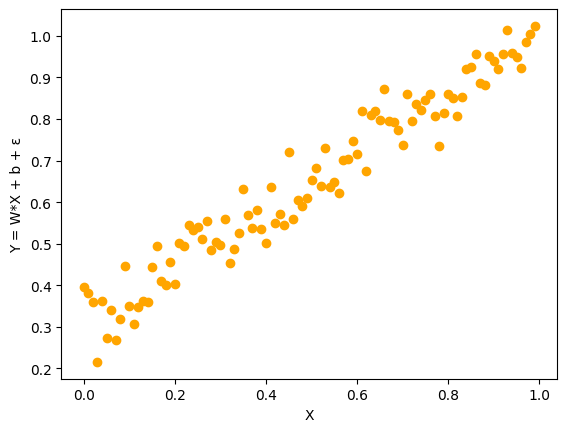

In [218]:
# Visualize data
plt.scatter(X.cpu().numpy(), Y.cpu().numpy(), color="orange")
plt.xlabel("X")
plt.ylabel("Y = W*X + b + \u03B5")

### Split the data into training and testing sets

In [219]:
# Shuffle data
# Otherwise, the test data will be the last 20% of the data, which cannot
# test the model's ability to generalize to unseen data everywhere
shuffle = torch.randperm(X.shape[0])
X, Y = X[shuffle], Y[shuffle]

# Move data to device
X, Y = X.to(device), Y.to(device)

train_split = int(0.8 * X.shape[0])  # 80% of data for training
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]


print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: torch.Size([80])
Y_train shape: torch.Size([80])
X_test shape: torch.Size([20])
Y_test shape: torch.Size([20])


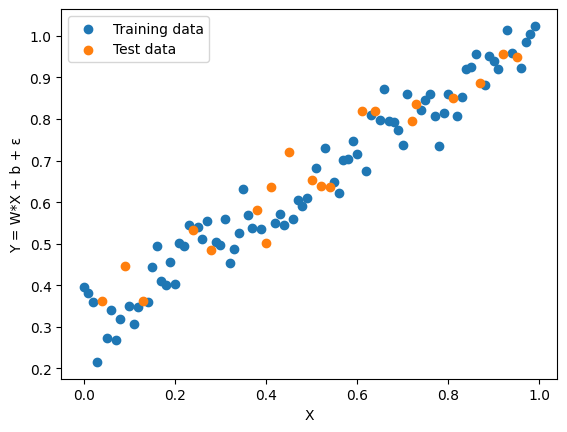

In [220]:
def tensor_to_np(tensor):
    return tensor.cpu().numpy() if tensor is not None else tensor


def plot_predictions(X_train, Y_train, X_test, Y_test, Y_pred=None):
    X_train, Y_train, X_test, Y_test, Y_pred = map(
        tensor_to_np, [X_train, Y_train, X_test, Y_test, Y_pred]
    )

    plt.rcParams["axes.prop_cycle"].by_key()["color"]

    plt.scatter(X_train, Y_train, label="Training data")
    plt.scatter(X_test, Y_test, label="Test data")
    plt.xlabel("X")
    plt.ylabel("Y = W*X + b + \u03B5")

    if Y_pred is not None:
        plt.scatter(X_test, Y_pred, label="Predictions")

        # Plot difference in Y values between test data and predictions
        for x, y_test, y_pred in zip(X_test, Y_test, Y_pred):
            plt.plot(
                [x, x],
                [y_test, y_pred],
                color="red",
                linewidth=1,
                linestyle="--",
                alpha=0.5,
            )

    plt.legend()


plot_predictions(X_train, Y_train, X_test, Y_test)

If we had not shuffled, in the graph we would see that the training set is all the data from 0 to 80% of the data, and the testing set is the remaining 20% of the data. So only the points on the right side of the graph would be blue (used for testing). This would be bad becausethe test points wouldn't capture how we do when x is below the 0.8 split.

## 2. Building the Model

1. Start with random rank 0 tensor for weights and bias
2. Run gradient descent and backpropagation to optimize the weights and bias

In [221]:
class LinearRegressionModel(nn.Module):
    # almost everything uses nn.Module

    def __init__(self):
        super().__init__()

        # or use nn.Linear with input_dim=1 and output_dim=1
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True))

    # Defines the forward computation
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # The input X is the training data
        # We want it to return the predictions
        return self.weight * X + self.bias

In [222]:
model = LinearRegressionModel()
model.to(device)

# Show the parameters
parameters = model.state_dict()
for k, v in parameters.items():
    print(f"{k}: {v}")

weight: tensor([1.7588], device='mps:0')
bias: tensor([-1.8872], device='mps:0')


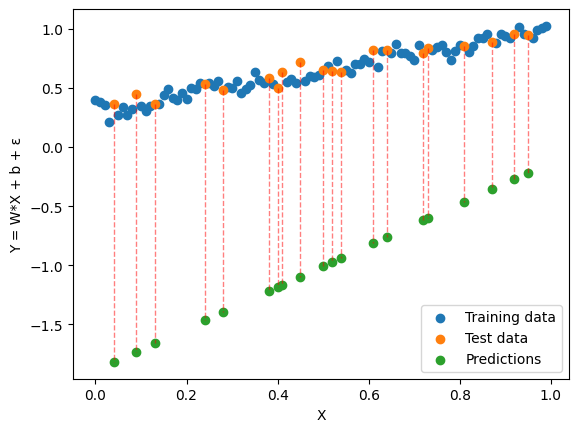

In [223]:
# Test model's predictive power using inference mode.

# torch.no_grad() is also OK, but torch.inference_mode() is more efficient
with torch.inference_mode():
    Y_pred = model(X_test)
    plot_predictions(X_train, Y_train, X_test, Y_test, Y_pred)

## 3. Training the Model

1. Define the loss function to measure how well the model is doing. (Also called cost function or criterion.)
2. Define the optimizer to update the parameters of the model based on the loss. (Also called the training operator.)

In [224]:
# Loss function
loss_fn = nn.MSELoss()

# Optimizer
learning_rate = 0.1  # schedulers could be used to change learning rate over time.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training and Testing Loop

Training Loop
1. Loop through the data points in the training set
2. Forward pass: compute the predicted y by passing x to the model.
3. Calculate the loss (how far is the predicted y from the actual y)
4. Optimizer zero grad
5. Propagate loss backwards. Calculate the gradients of the model parameters (weight and bias) with respect to the loss. (Back-propagation)
6. Use the optimizer to update the model parameters with the gradients. (Gradient descent)

In [225]:
# Training loop
total_epochs = 500  # Number of times to iterate over the entire dataset
train_loss_values = np.zeros(total_epochs)  # Store loss values for plotting
test_loss_values = np.zeros(total_epochs)  # Store loss values for plotting

for epoch in tqdm(range(total_epochs), desc="Training", unit="epochs"):
    # Set the model to training mode
    model.train()  # Sets all parameters that require grad to True

    # Forward pass
    Y_train_pred = model(X_train)

    # Compute loss
    loss = loss_fn(Y_train_pred, Y_train)
    train_loss_values[epoch] = loss.item()

    # Zero gradients
    optimizer.zero_grad()  # Sets gradients of all parameters to zero

    # Backward pass
    loss.backward()

    # Step optimizer
    # Updates parameters using gradients and learning rate
    # by default, this accumulates gradients on every call, so we need to zero them
    # with optimizer.zero_grad() before calling it
    optimizer.step()

    # Testing the model as wel go
    model.eval()  # Sets all parameters that require grad to False
    with torch.inference_mode():
        Y_test_pred = model(X_test)
        test_loss = loss_fn(Y_test_pred, Y_test)
        test_loss_values[epoch] = test_loss.item()

    # Print progress
    if epoch % 10 == 0:
        print(
            f"Epoch {epoch} | Train loss = {loss.item():.4f} | Test loss = {test_loss.item():.4f}"
        )

Training:   0%|          | 0/500 [00:00<?, ?epochs/s]

Epoch 0 | Train loss = 2.8785 | Test loss = 1.6822
Epoch 10 | Train loss = 0.2088 | Test loss = 0.1715
Epoch 20 | Train loss = 0.1530 | Test loss = 0.1289
Epoch 30 | Train loss = 0.1166 | Test loss = 0.0993
Epoch 40 | Train loss = 0.0890 | Test loss = 0.0767
Epoch 50 | Train loss = 0.0681 | Test loss = 0.0595
Epoch 60 | Train loss = 0.0522 | Test loss = 0.0464
Epoch 70 | Train loss = 0.0402 | Test loss = 0.0363


Training:  35%|███▌      | 177/500 [00:00<00:00, 881.69epochs/s]

Epoch 80 | Train loss = 0.0310 | Test loss = 0.0286
Epoch 90 | Train loss = 0.0241 | Test loss = 0.0227
Epoch 100 | Train loss = 0.0189 | Test loss = 0.0182
Epoch 110 | Train loss = 0.0149 | Test loss = 0.0147
Epoch 120 | Train loss = 0.0119 | Test loss = 0.0120
Epoch 130 | Train loss = 0.0096 | Test loss = 0.0100
Epoch 140 | Train loss = 0.0078 | Test loss = 0.0084
Epoch 150 | Train loss = 0.0065 | Test loss = 0.0072
Epoch 160 | Train loss = 0.0055 | Test loss = 0.0062
Epoch 170 | Train loss = 0.0048 | Test loss = 0.0055
Epoch 180 | Train loss = 0.0042 | Test loss = 0.0049
Epoch 190 | Train loss = 0.0038 | Test loss = 0.0044
Epoch 200 | Train loss = 0.0034 | Test loss = 0.0041
Epoch 210 | Train loss = 0.0032 | Test loss = 0.0038
Epoch 220 | Train loss = 0.0030 | Test loss = 0.0035
Epoch 230 | Train loss = 0.0028 | Test loss = 0.0034
Epoch 240 | Train loss = 0.0027 | Test loss = 0.0032
Epoch 250 | Train loss = 0.0026 | Test loss = 0.0031
Epoch 260 | Train loss = 0.0026 | Test loss = 0.

Training:  72%|███████▏  | 359/500 [00:00<00:00, 898.29epochs/s]

Epoch 270 | Train loss = 0.0025 | Test loss = 0.0029
Epoch 280 | Train loss = 0.0025 | Test loss = 0.0029
Epoch 290 | Train loss = 0.0025 | Test loss = 0.0028
Epoch 300 | Train loss = 0.0024 | Test loss = 0.0028
Epoch 310 | Train loss = 0.0024 | Test loss = 0.0028
Epoch 320 | Train loss = 0.0024 | Test loss = 0.0027
Epoch 330 | Train loss = 0.0024 | Test loss = 0.0027
Epoch 340 | Train loss = 0.0024 | Test loss = 0.0027
Epoch 350 | Train loss = 0.0024 | Test loss = 0.0027
Epoch 360 | Train loss = 0.0024 | Test loss = 0.0027


Training:  90%|████████▉ | 449/500 [00:00<00:00, 897.28epochs/s]

Epoch 370 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 380 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 390 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 400 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 410 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 420 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 430 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 440 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 450 | Train loss = 0.0024 | Test loss = 0.0026


Training: 100%|██████████| 500/500 [00:00<00:00, 867.28epochs/s]

Epoch 460 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 470 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 480 | Train loss = 0.0024 | Test loss = 0.0026
Epoch 490 | Train loss = 0.0024 | Test loss = 0.0026


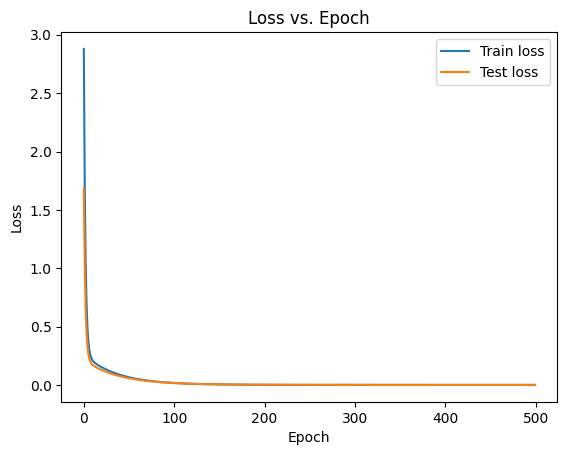

In [226]:
# Plot loss
plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.plot(train_loss_values, label="Train loss")
plt.plot(test_loss_values, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

## 4. Testing the Model

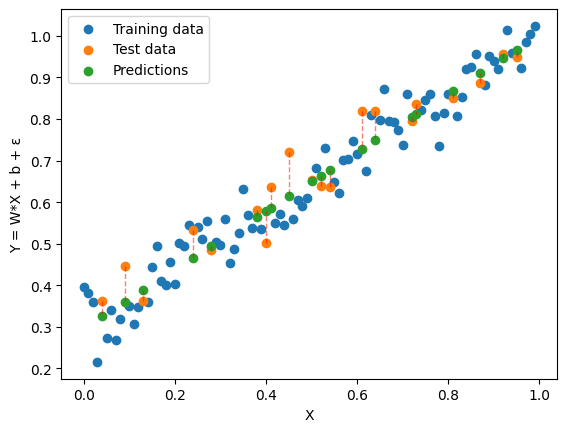

In [227]:
with torch.inference_mode():
    Y_pred = model(X_test)
    plot_predictions(X_train, Y_train, X_test, Y_test, Y_pred)

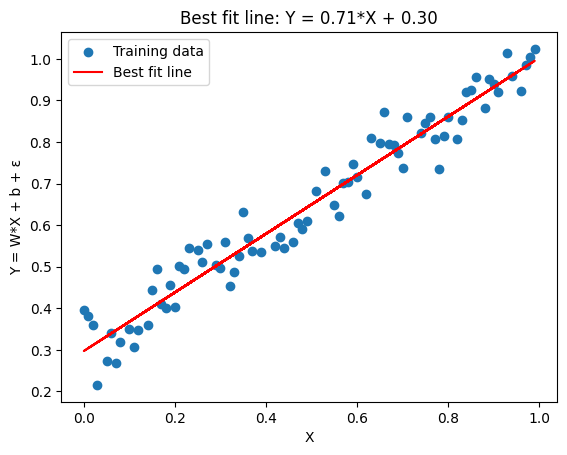

In [228]:
# Get the final parameters
W_hat = model.weight.item()
b_hat = model.bias.item()
Y_pred = W_hat * X + b_hat


# Plot the training data and the best fit line
def plot_bestfit(X_train, Y_train, X, Y_pred):
    X_train, Y_train, X, Y_pred = map(tensor_to_np, [X_train, Y_train, X, Y_pred])
    plt.rcParams["axes.prop_cycle"].by_key()["color"]

    plt.scatter(X_train, Y_train, label="Training data")
    plt.plot(X, Y_pred, label="Best fit line", color="red")
    plt.xlabel("X")
    plt.ylabel("Y = W*X + b + \u03B5")
    plt.title(f"Best fit line: Y = {W_hat:.2f}*X + {b_hat:.2f}")
    plt.legend()


plot_bestfit(X_train, Y_train, X, Y_pred)

## 5. Saving and Loading Models

1. torch.save(): Saves the model as a pickle file
2. torch.load(): Loads the model from the pickle file
3. torch.nn.Module.load_state_dict(): Loads the model's parameter dictionary using a deserialized state_dict

In [229]:
# Save the model
from pathlib import Path

# Get the parent folder of the file
model_dir = Path("models")

# Create the folder if it doesn't exist
model_dir.mkdir(parents=True, exist_ok=True)

# Save the model's parameters
torch.save(model.state_dict(), model_dir / "01_linear_regression_model.pt")

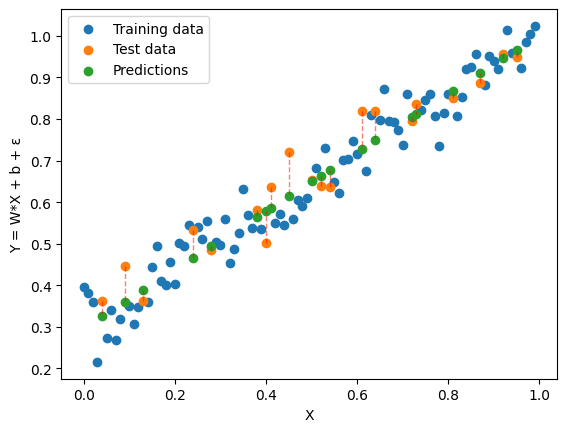

In [230]:
# Loading
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(model_dir / "01_linear_regression_model.pt"))
loaded_model.to(device)

loaded_model.eval()
with torch.inference_mode():
    Y_pred = loaded_model(X_test)
    plot_predictions(X_train, Y_train, X_test, Y_test, Y_pred)